In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data: float, _children: tuple = (), _op: str = "", label: str = ""): 
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.label = label
        self._prev = set(_children)
        self._op = _op

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), _op="+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), _op="*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        out = Value((np.exp(2 * x) - 1) / (np.exp(2 * x) + 1), (self, ), _op="tanh")
        
        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topological_sort(child)
                topo.append(v)
        build_topological_sort(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __repr__(self): 
        return f"Value(data={self.data})"

In [3]:
a = Value(-5)
a

Value(data=-5)

In [4]:
b = Value(1)
b

Value(data=1)

In [5]:
a + b

Value(data=-4)

In [6]:
a * b

Value(data=-5)

### Define a simple network (or DAG)

In [7]:
def forward(a: Value, b: Value, c: Value, f: Value) -> Value:
    e = a * b; e.label = "e"
    d = c + e; d.label = "d"
    L = d * f; L.label = "L"
    
    return L, (a, b, c, d, e, f)

In [8]:
a, b, c, f = Value(2, label="a"), Value(-3, label="b"), Value(10, label="c"), Value(-2, label="f")

L, (a, b, c, d, e, f) = forward(a, b, c, f)
L

Value(data=-8)

In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

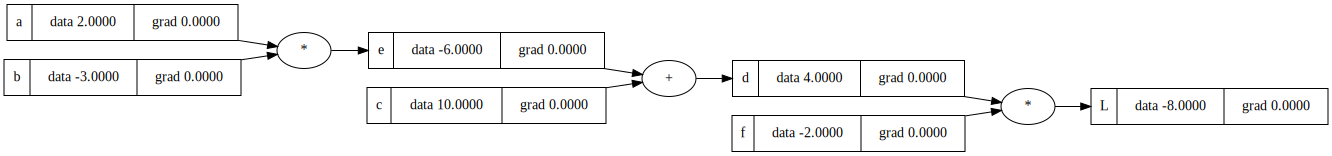

In [10]:
draw_dot(L)

### Manually computing the gradients

In [11]:
def backward(): 
    # use the chain rule!
    L.grad = 1                    # dL/dL = (L + h) - L / h = h / h = 1 
    d.grad = f.data               # dL/dd = ((d * h) * f - df ) / h = hf / h = f
    f.grad = d.data               # dL/df = ((f * h) * d - df ) / h = dh / h = d
    c.grad = d.grad * 1           # dL/dc = dL/dd * dd/dc = dL/dd * ((c + h) + e) - c - e) / h 
    e.grad = d.grad * 1           # dL/de = dL/dd * dd/de
    a.grad = d.grad * 1 * b.data  # dL/da = dL/dd * dd/de * de/da
    b.grad = d.grad * 1 * a.data  # dL/db = dL/dd * dd/de * de/db

In [12]:
backward()

In [13]:
for i in (a, b, c, d, e, f, L):
    print(f"{i.label}.grad = {i.grad}")

a.grad = 6
b.grad = -4
c.grad = -2
d.grad = -2
e.grad = -2
f.grad = 4
L.grad = 1


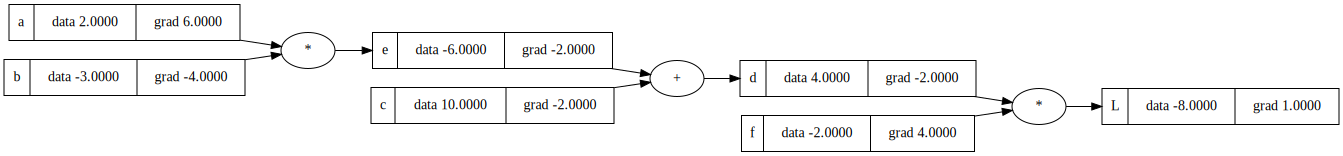

In [14]:
draw_dot(L)

### Let's define a simple neuron

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*T4ARzySpEQvEnr_9pc78pg.jpeg)

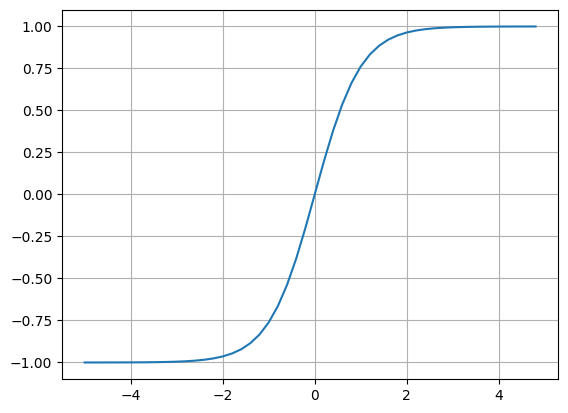

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(-5, 5, .2), np.tanh(np.arange(-5, 5, .2)))
plt.grid()

In [16]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [17]:
o.grad = 1.0
n.grad = 1 - o.data**2  # do/dn = 1 - tanh(o)**2 = 1 - o**2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

In [18]:
for i in (o, n, b, x1w1x2w2, w1, w2):
    print(f"{i.label}.grad = {i.grad}")

o.grad = 1.0
n.grad = 0.4999999999999999
b.grad = 0.4999999999999999
x1*w1 + x2*w2.grad = 0.4999999999999999
w1.grad = 0.9999999999999998
w2.grad = 0.0


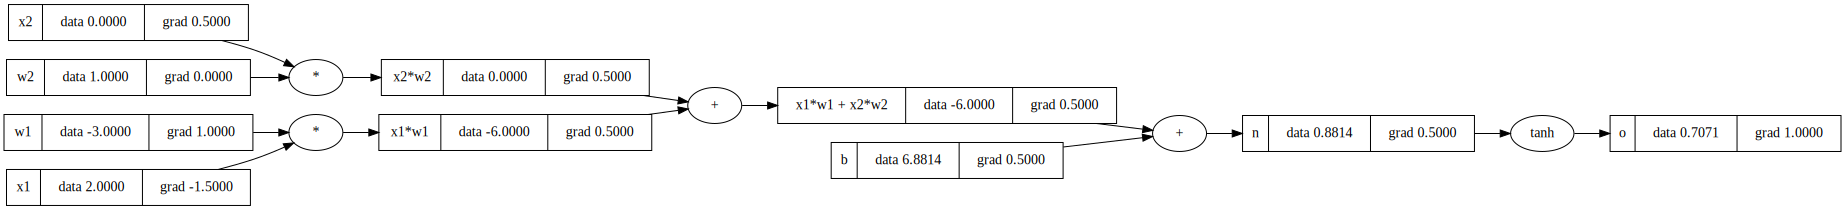

In [19]:
draw_dot(o)

Interestingly, $\frac{\partial{o}}{\partial{w2}}$ is 0. Why? Since, `x2.data` is $0$, no matter how much we change `w2`, the result of multiply `x2` by `w2` will always result to 0 ― and therefore, will always have no influence on the final output `o`.

### Let's automate the computation of the gradients using the `_backward()` method

In [20]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

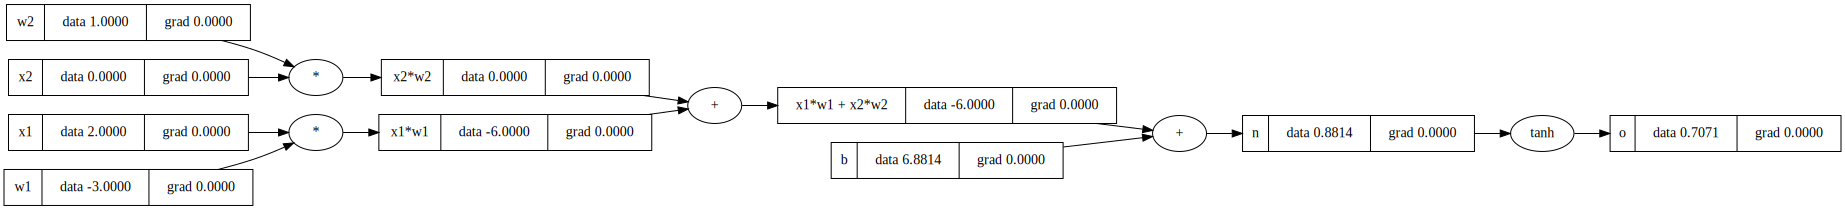

In [21]:
# visual check that gradients are not computed yet
draw_dot(o)

In [22]:
o.backward()

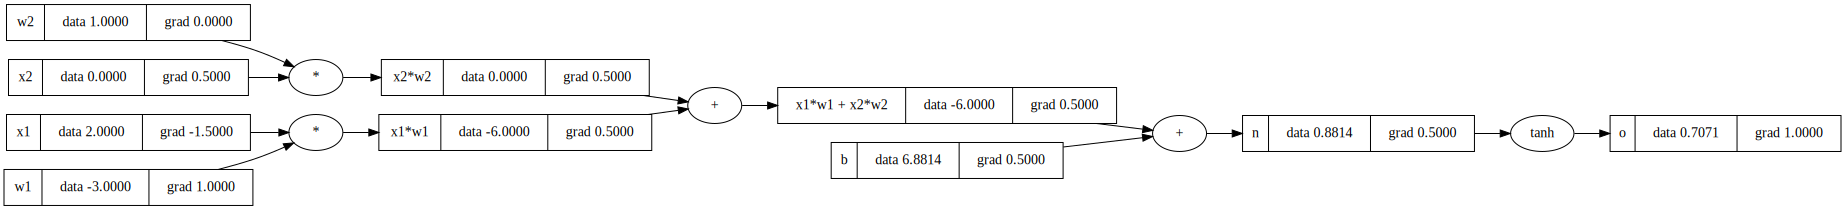

In [23]:
draw_dot(o)

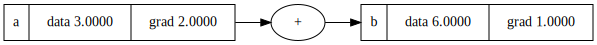

In [24]:
a = Value(3.0, label="a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)

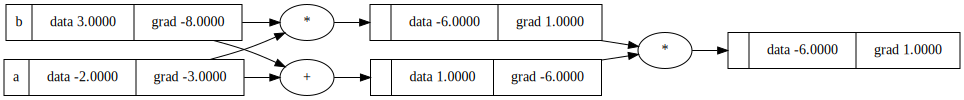

In [25]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a * b
e = a + b
f = d * e

f.backward()
draw_dot(f)